# Compare waterbody polygons with the Geofabric

This notebook compares some DEA Waterbodies polygons with the corresponding Geofabric polygons for validation.

In [33]:
import geopandas as gpd
import networkx as nx
import numpy as np

In [102]:
gfb = gpd.read_file('wb_validation/FarmDamsGeofabric.shp').to_crs('EPSG:3577')
wbs = gpd.read_file('wb_validation/FarmDamsWB.shp')

# gfb = gpd.read_file('wb_validation/WASaltLakesGeofabric.shp').to_crs('EPSG:3577')
# wbs = gpd.read_file('wb_validation/WASaltLakesWB.shp')

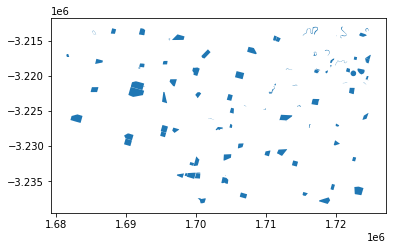

In [103]:
gfb.plot()

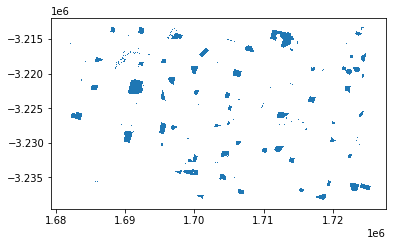

In [104]:
wbs.plot()

In [105]:
diff_wg = gpd.overlay(wbs, gfb, 'difference')
diff_gw = gpd.overlay(gfb, wbs, 'difference')

(8.997683056554335, 2.81315332955922)

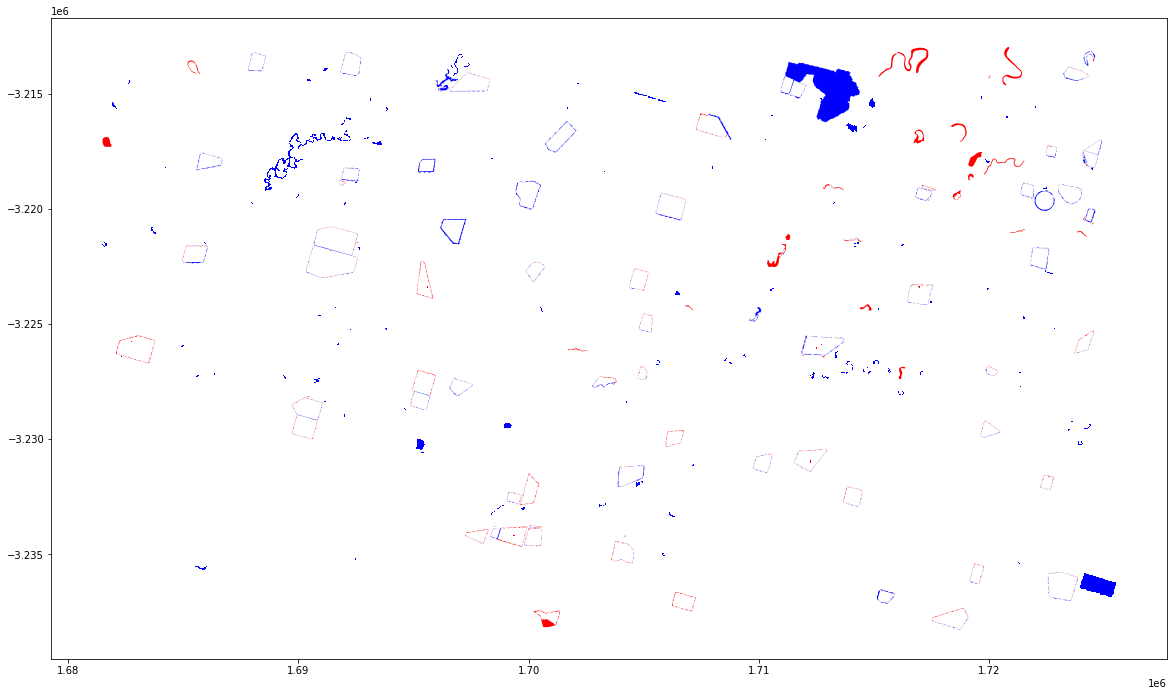

In [106]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
diff_wg.plot(fc='blue', ax=ax)
diff_gw.plot(fc='red', ax=ax)
diff_wg.area.sum() / 1000000, diff_gw.area.sum() / 1000000  # m² -> km²

Identify each waterbody in each dataset.

In [107]:
no_matches_in_wbs = []
matches = []  # (gfb, wbs)
for i, poly in gfb.iterrows():
    inter = wbs.intersection(poly.geometry)
    inter = inter[~inter.is_empty]
    if len(inter) == 0:
        no_matches_in_wbs.append(i)
        continue
    for j in inter.index:
        matches.append((('g', i), ('w', j)))

Disjoint sets.

In [108]:
G = nx.Graph()
G.add_edges_from(matches)

In [109]:
djs = list(nx.connected_components(G))

In [110]:
diff_areas_gw = []
diff_areas_wg = []
area_diffs = []
for wset in djs:
    gpoly = gpd.GeoDataFrame([gfb.iloc[idx] for source, idx in wset if source == 'g'])
    wpoly = gpd.GeoDataFrame([wbs.iloc[idx] for source, idx in wset if source == 'w'])
    diff_area = (gpoly.buffer(0).unary_union - wpoly.buffer(0).unary_union).area
    diff_areas_gw.append(diff_area)
    diff_area = (wpoly.buffer(0).unary_union - gpoly.buffer(0).unary_union).area
    diff_areas_wg.append(diff_area)
    area_diff = wpoly.buffer(0).unary_union.area - gpoly.buffer(0).unary_union.area
    area_diffs.append(area_diff)

Text(0.5, 0, 'Area (m$^2$)')

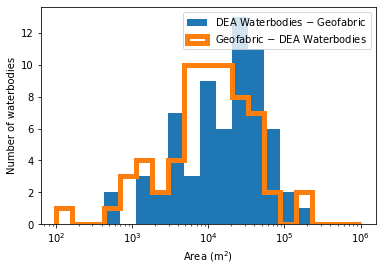

In [113]:
plt.hist(diff_areas_wg, bins=np.logspace(2, 6, 20), label='DEA Waterbodies $-$ Geofabric')
plt.hist(diff_areas_gw, bins=np.logspace(2, 6, 20), histtype='step', label='Geofabric $-$ DEA Waterbodies', lw=5)
plt.xscale('log')
plt.legend()
plt.ylabel('Number of waterbodies')
plt.xlabel('Area (m$^2$)')

Text(0, 0.5, 'Number of waterbodies')

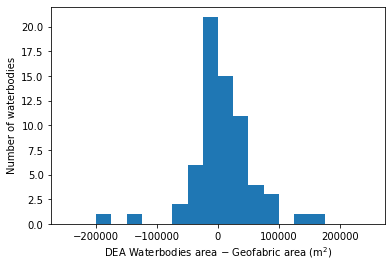

In [112]:
plt.hist(area_diffs, range=(-2.5e5, 2.5e5), bins=20);
plt.xlabel('DEA Waterbodies area $-$ Geofabric area (m$^2$)')
plt.ylabel('Number of waterbodies')